In [8]:
import torch
import pandas as pd
import sklearn
import torch



In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")   # Use CPU
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [10]:
from torch.utils.data import Dataset

class ChessData(Dataset):
    def __init__(self, board_datafile, move_datafile):
        self.chess_boards = torch.load(board_datafile)
        self.chess_moves = torch.load(move_datafile)

    def __len__(self):
        return len(self.chess_boards)

    def __getitem__(self, index):
        input_board = self.chess_boards[index]
        output_pos = self.chess_moves[index]
        return input_board, output_pos
    






    

Training LR: 0.01
|--------------------
|####################

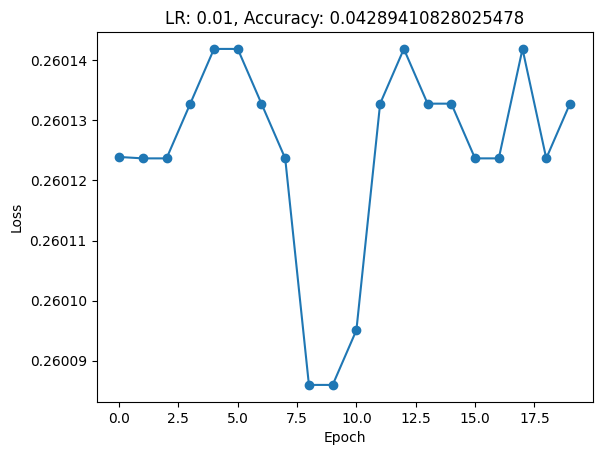

Training LR: 0.0031622776601683794
|--------------------
|####################

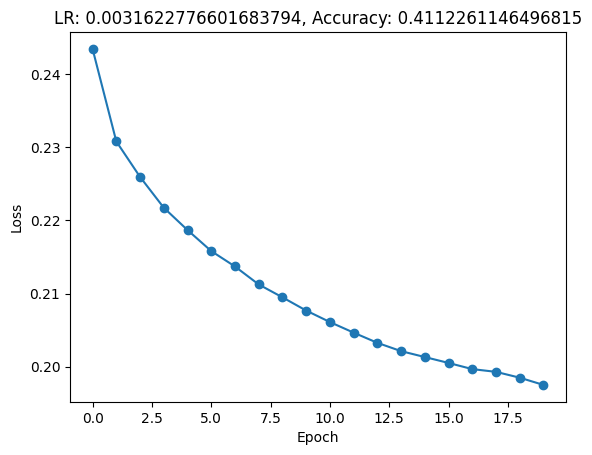

Training LR: 0.001
|--------------------
|####################

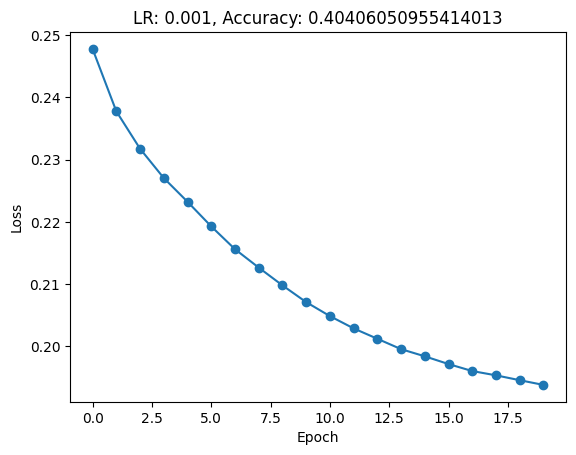

Training LR: 0.00031622776601683794
|--------------------
|####################

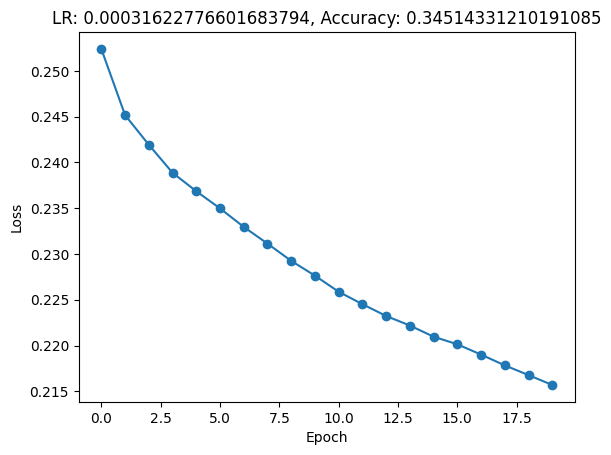

Training LR: 0.0001
|--------------------
|####################

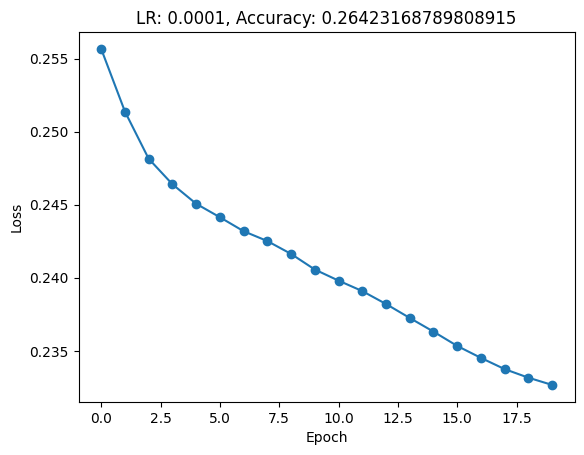

Training LR: 3.1622776601683795e-05
|--------------------
|####################

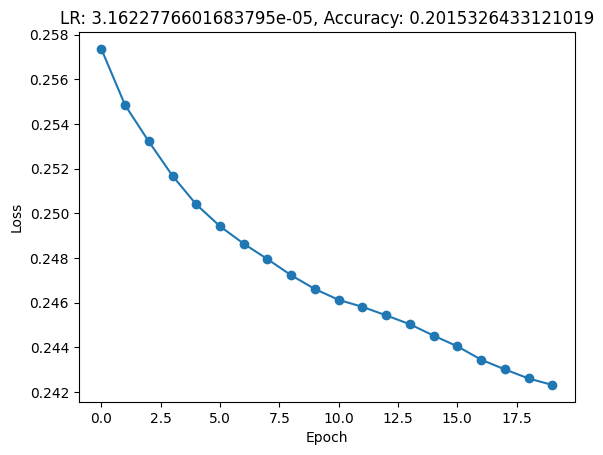

Training LR: 1e-05
|--------------------
|####################

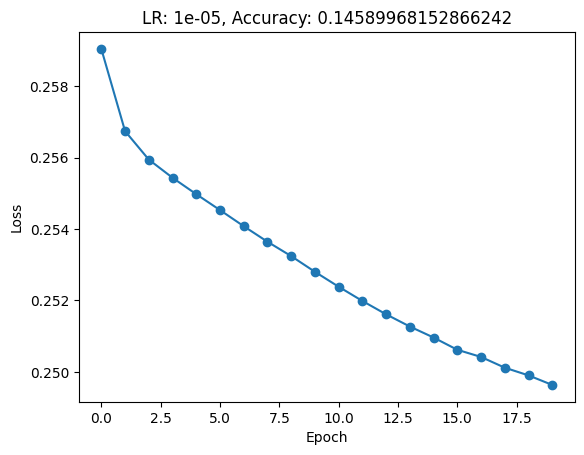

Training LR: 3.162277660168379e-06
|--------------------
|####################

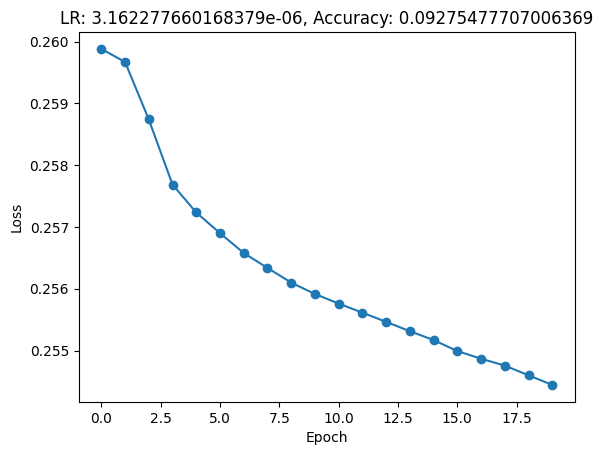

Training LR: 1e-06
|--------------------
|####################

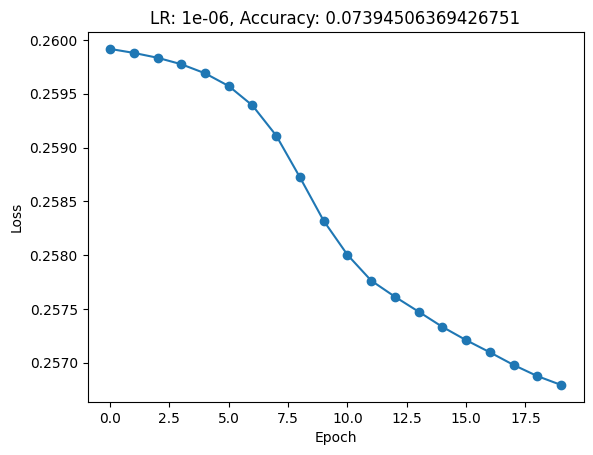

Training LR: 3.162277660168379e-07
|--------------------
|####################

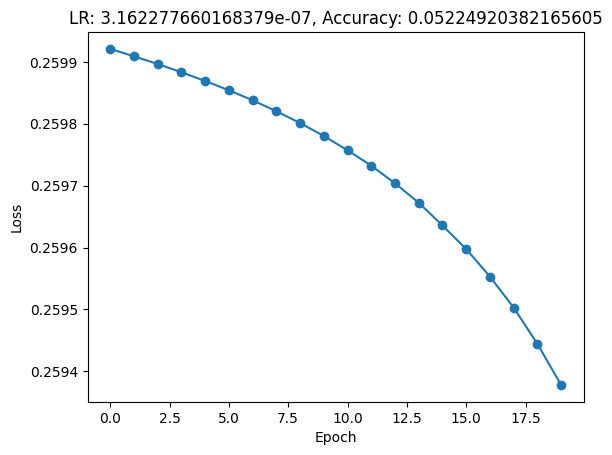

0.0031622776601683794


In [11]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.utils.data as data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



chess_data = ChessData("datasets/chess_boards_m1.pt", "datasets/chess_moves_m1.pt")

class Chess_CNN(nn.Module):
    def __init__(self):
        super(Chess_CNN, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        # self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        # self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * 32, 1024)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 64)

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.relu1(x)
        # x = self.conv2(x)
        # x = self.relu2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = nn.functional.softmax(x, dim=1)
        x = x.view(x.size(0), 8, 8)
        return x

torch.manual_seed(123)

# Create a DataLoader for training
batch_size = 64
# Split the dataset into train and validation sets
train_indices, val_indices = train_test_split(list(range(len(chess_data))), test_size=0.2, random_state=42)

# Create Samplers for train and validation sets
train_sampler = data.SubsetRandomSampler(train_indices)
val_sampler = data.SubsetRandomSampler(val_indices)

# Create DataLoaders for train and validation sets
train_loader = DataLoader(chess_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(chess_data, batch_size=batch_size, sampler=val_sampler)


learning_rates = [10 ** -i for i in [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]]
cache = []

best_acc = 0
best_lr = -1

for lr in learning_rates:
    # Initialize your neural network
    model = Chess_CNN()

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_hist = []
    # Training loop
    num_epochs = 20
    print(f"Training LR: {lr}")
    print("|" + "-" * num_epochs)
    print("|", end = "")

    for epoch in range(num_epochs):
        total_loss = 0
        total_batches = 0
        for inputs, targets in train_loader:
            targets = targets.float()
            inputs = inputs.float()


            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            #loss.requires_grad = True
            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Track avg loss
            total_loss += loss.item()
            total_batches += 1  
        
        avg_loss = total_loss / total_batches

        total_correct = 0
        total_samples = 0
        # Print progress
        #print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Accuracy: {accuracy}")
        loss_hist.append((epoch, avg_loss))
        print("#", end = "")
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_outputs = val_outputs.view(batch_size, -1)
            val_targets = val_targets.view(batch_size, -1)
            _, predicted_labels = torch.max(val_outputs, dim=1)
            _, target_labels = torch.max(val_targets, dim=1)

            total_correct += (predicted_labels == target_labels).sum().item()
            total_samples += val_targets.size(0)

    accuracy = total_correct / total_samples

    if accuracy > best_acc:
        best_acc = accuracy
        best_lr = lr

    epochs, loss_values = zip(*loss_hist)

    # Create the line plot
    plt.plot(epochs, loss_values, marker='o', linestyle='-')

    # Set plot labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'LR: {lr}, Accuracy: {accuracy}')

    # Show the plot
    plt.show()

    cache.append([lr, accuracy, loss_hist])

print(best_lr)